In [2]:
%load_ext autoreload
%autoreload 1
%aimport utils_timeline_viz
from utils_timeline_viz import *
from utils_read_parsing import *
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 7, 4
from tabulate import tabulate
pd.options.mode.chained_assignment = None

## Loading and preparing survey data

In [4]:
pre = get_pre_survey()

In [5]:
pre.head(2)

Status  Internal ID Language        Created At        Updated At  \
0  Complete     83736373  English  2017-01-13 13:17  2017-01-13 13:19   
1  Complete     83736382  English  2017-01-13 13:17  2017-01-13 13:19   

           Location  Username  GET Variables  \
0  British Columbia       NaN            NaN   
1  British Columbia       NaN            NaN   

                                  Referrer  Number of Saves  \
0  https://survey.ubc.ca/s/pre-assessment/              NaN   
1  https://survey.ubc.ca/s/pre-assessment/              NaN   

                                                               ...                                                                \
0                                                              ...                                                                 
1                                                              ...                                                                 

   [taskinterpretation.0] When I am asked to do an activity like the one shown, I am being asked to... | investigate the basic mechanics of the topic at hand  \
0                                             Mostly                                                                                                            
1                                           Somewhat                                                                                                            

  [taskinterpretation.1] When I am asked to do an activity like the one shown, I am being asked to... | design my own experiments that can help me understand the topic at hand  \
0                                         Definitely                                                                                                                              
1                                             Mostly                                                                                                                              

   [taskinterpretation.2] When I am asked to do an activity like the one shown, I am being asked to... | memorize information about the topic at hand  \
0                                         Not at all                                                                                                    
1                                           Somewhat                                                                                                    

   [taskinterpretation.3] When I am asked to do an activity like the one shown, I am being asked to... | complete a certain number of  questions  \
0                                           Somewhat                                                                                               
1                                           Somewhat                                                                                               

  [taskinterpretation.4] When I am asked to do an activity like the one shown, I am being asked to... | develop scientific reasoning skills  \
0                                             Mostly                                                                                          
1                                           Somewhat                                                                                          

   [pocc.0] When doing an activity to learn physics through a virtual lab, I think I can do a good job of | learning the basic concepts  \
0                                      Almost always                                                                                       
1                                              Often                                                                                       

   [pocc.1] When doing an activity to learn physics through a virtual lab, I think I can do a good job of | testing my ideas and theories  \
0                                      Almost always                                                                                 

In [6]:
#cleaning up columns
old_columns = list(pre.columns)
new_columns = [c.split(']')[0].replace('[','') for c in old_columns]
for i,(c,d) in enumerate(zip(new_columns,old_columns)):
    if new_columns.count(c)>1:
        new_columns[i] = d
print new_columns
pre.columns = new_columns

[u'Status', u'Internal ID', u'Language', u'Created At', u'Updated At', u'Location', u'Username', u'GET Variables', u'Referrer', u'Number of Saves', u'Weighted Score', u'Completion Time', u'Page 1 | Time on Page', u'Page 2 | Time on Page', u'IP Address', u'Invite Code', u'Invite Email', u'Invite Name', u'Collector', u'id', u'[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [High school level laboratory]', u'[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [First year undergraduate physics laboratory]', u'[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [First year undergraduate chemistry laboratory]', u'[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [Higher level physics labs]', u'[prior_lab] What lab courses are you presently taking or have taken in the past? Check all th

## Keep records if analyzable ids

In [7]:
ids = set(get_students_to_analyze_log())

In [8]:
len(ids)

148

In [9]:
import collections
ids_pre = list(pre['id'])
print len(ids_pre), len(set(ids_pre))
print [item for item, count in collections.Counter(ids_pre).items() if count > 1]
print "We have duplicates, one from the collision and one from... who knows!"
print 17931169 in ids

206 204
[23784336, 17931169]
We have duplicates, one from the collision and one from... who knows!
True


In [10]:
print len(ids&set(ids_pre)),"ids in pre and analyzable list"
print  len(ids - set(ids_pre)),"ids not in pre"
print len(set(ids_pre)-ids),"ids not analyzable ids (not worrisome - lots of testing or unusable students)"

135 ids in pre and analyzable list
13 ids not in pre
69 ids not analyzable ids (not worrisome - lots of testing or unusable students)


In [11]:
ids_to_sort = set(ids - set(ids_pre))
for idd in ids_to_sort:
    print idd, int(str(idd)[1:]) in ids_pre
print len(ids_to_sort)

15055169 True
15444164 True
19780165 True
12406161 False
17868168 True
16901162 True
10561164 True
13981167 True
10192168 True
18162165 False
15298166 True
11394167 True
14055131 True
13


In [12]:
def ids_logs_to_pre(studentid):
    if studentid in [15055169,15444164,19780165,17868168,16901162,10561164,13981167,10192168,15298166,11394167,14055131]:
        return studentid-10000000
    elif studentid == 12406161:
        return 12406816
    elif studentid == 18162165:
        return 18162136
    else:
        return studentid
    
def ids_pre_to_logs(studentid):
    if studentid in [5055169,5444164,9780165,7868168,6901162,561164,3981167,192168,5298166,1394167,4055131]:
        return studentid+10000000
    elif studentid == 12406816:
        return 12406161
    elif studentid == 18162136:
        return 18162165
    else:
        return studentid
ids_match_pre = set([ids_logs_to_pre(i) for i in ids])
print len(ids_match_pre)
print len(ids_match_pre&set(ids_pre))

148
148


In [13]:
#using internal id to remove the student with two pres,one in a good session with logs, one not
#id = 17931169
pre_analyzeable = pre[(pre['id'].isin(ids_match_pre))&(pre['Internal ID']!=86221654)]
len(pre_analyzeable)

148

## Let's analyze!

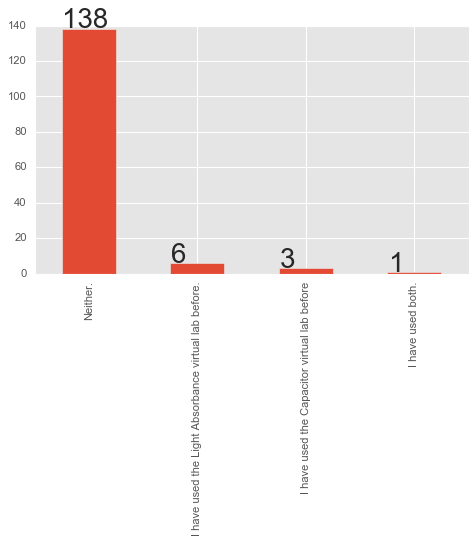

In [14]:
ax = pre_analyzeable['prior_sims_phet'].value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005), fontsize=25)

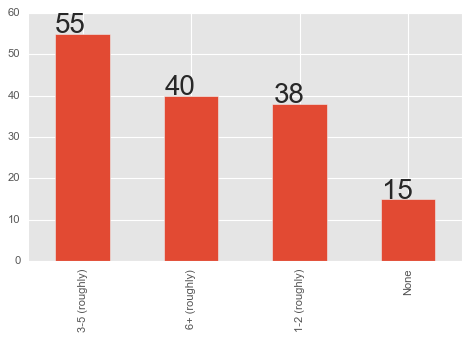

In [15]:
ax = pre_analyzeable['prior_number_virtual_labs'].value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005), fontsize=25)

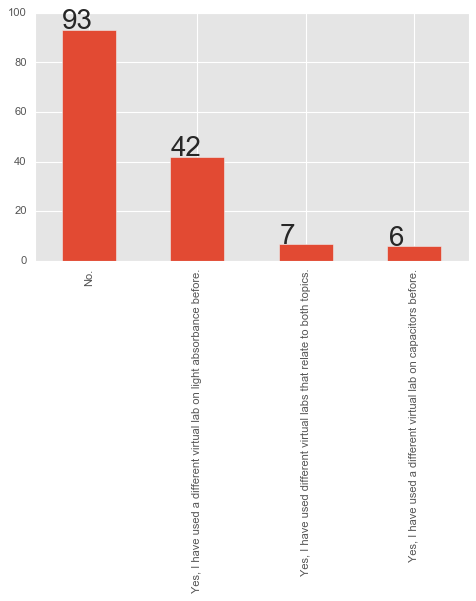

In [16]:
ax = pre_analyzeable['prio_sims_other'].value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005), fontsize=25)

In [17]:
lab_choices = ['[High school level laboratory]','[First year undergraduate physics laboratory]','[First year undergraduate chemistry laboratory]','[Higher level physics labs]','[Higher level chemistry labs]']
p = []
p.append(lab_choices)
p.append([len(pre_analyzeable[pre_analyzeable['[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. '+choice]==1]) for choice in lab_choices])
print tabulate(p)
# len(pre_analyzeable[pre_analyzeable['[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [High school level laboratory]']==1])

------------------------------  ---------------------------------------------  -----------------------------------------------  ---------------------------  -----------------------------
[High school level laboratory]  [First year undergraduate physics laboratory]  [First year undergraduate chemistry laboratory]  [Higher level physics labs]  [Higher level chemistry labs]
126                             116                                            116                                              0                            11
------------------------------  ---------------------------------------------  -----------------------------------------------  ---------------------------  -----------------------------


In [18]:
pre_analyzeable.columns

Index([u'Status', u'Internal ID', u'Language', u'Created At', u'Updated At',
       u'Location', u'Username', u'GET Variables', u'Referrer',
       u'Number of Saves', u'Weighted Score', u'Completion Time',
       u'Page 1 | Time on Page', u'Page 2 | Time on Page', u'IP Address',
       u'Invite Code', u'Invite Email', u'Invite Name', u'Collector', u'id',
       u'[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [High school level laboratory]',
       u'[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [First year undergraduate physics laboratory]',
       u'[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [First year undergraduate chemistry laboratory]',
       u'[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [Higher level physics labs]',
       u'[prior_lab] What lab cou

In [19]:
#Other lab courses taken by students
print  [v for v in pre_analyzeable['prior_lab'].values if str(v) != 'nan']

[u'Chem 154 lab', u'Biology', u'biol 140', u'First year undergraduate biology laboratory ', u'First year undergraduate Computer Science and Astromony laboratory', u'First Year undergraduate CPSC labs', u'Chemistry High School level', u'first year biology lab', u'Computer Science labs', u'Biology 140 Lab Course ', u'Microbiology (High School)', u'Bio 140', u'Music Theory', u'Biology, Computer Science', u'Biology', u'First year Biology Laboratory', u'First Year Undergraduate Biology Lab', u'First year undergraduate biology labratory', u'VISA 110', u'computer science labs', u'High school level biology lab, First year undergraduaute biology lab', u'Biology first year lab', u'First year undergraduate biology lab', u'Biology', u'First year undergraduate biology lab (BIOL 140)', u'Chemistry', u'high school biology lab', u'cpsc 121 and 110 labs', u'Biology labs', u'First year undergraduate biology laboratory', u'economics', u'Frst 443 - ENVI, Bio230/306', u'first year undergrad biology labs', 

## Make dataframe to add to analysis

In [42]:
def other_sim(sim,answer):
    if sim in answer or 'both' in answer:
        return 1
    else:
        return 0
convert_experience = {'1-2 (roughly)':1, '3-5 (roughly)':2, '6+ (roughly)':3, 'None':0}

#quantify in an ordinal variable how much virtual lab experience they have
pre_analyzeable['level_experience_sims'] = pre_analyzeable['prior_number_virtual_labs'].apply(lambda answer: convert_experience[answer])

#binarize their familiarity with similar topic per sim
pre_analyzeable['similar_L'] = pre_analyzeable['prio_sims_other'].apply(lambda answer: other_sim('light',answer))
pre_analyzeable['similar_C'] = pre_analyzeable['prio_sims_other'].apply(lambda answer: other_sim('capacitor',answer))

# "1" if they have undergraduate physics lab experience (zero students have higher level physics lab)
# ignore other lab experiences for simplicity
pre_analyzeable['experience_undergrad_lab_physics'] = pre_analyzeable['[prior_lab] What lab courses are you presently taking or have taken in the past? Check all that apply. [First year undergraduate physics laboratory]']
pre_analyzeable['experience_undergrad_lab_physics'].fillna(0, inplace=True)
pre_analyzeable['experience_undergrad_lab_physics'] = pre_analyzeable['experience_undergrad_lab_physics'].astype(int)
#convert all ids so they match ids in logs
pre_analyzeable['sid'] = pre_analyzeable['id'].apply(lambda i: ids_pre_to_logs(i))

COLUMNS = ['sid','level_experience_sims','similar_L','similar_C','experience_undergrad_lab_physics']

pre_analyzeable[COLUMNS].to_csv('pre_survey_results.txt', sep='\t')

In [43]:
pre_analyzeable[COLUMNS].describe()

sid  level_experience_sims   similar_L   similar_C  \
count  1.480000e+02             148.000000  148.000000  148.000000   
mean   2.204070e+07               1.810811    0.331081    0.087838   
std    1.807852e+07               0.950126    0.472200    0.284020   
min    1.012716e+07               0.000000    0.000000    0.000000   
25%    1.353541e+07               1.000000    0.000000    0.000000   
50%    1.670466e+07               2.000000    0.000000    0.000000   
75%    1.936215e+07               3.000000    1.000000    0.000000   
max    9.044717e+07               3.000000    1.000000    1.000000   

       experience_undergrad_lab_physics  
count                        148.000000  
mean                           0.783784  
std                            0.413061  
min                            0.000000  
25%                            1.000000  
50%                            1.000000  
75%                            1.000000  
max                            1.000000